# 6. Holdout set validation

Run the selected optimizer based on the training/validation sets to classify the holdout set.

#### Import the needed packages

In [2]:
%%capture
!pip install xgboost

In [3]:
import os
import pickle
import base64

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import (f1_score, precision_score, recall_score, roc_auc_score, accuracy_score, confusion_matrix)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

In [ ]:
label=os.getenv('label', 'Class')

#### Read the holdout data

In [7]:
holdout_path = os.getenv('holdoutpath', 'holdout.csv')
holdout_data = pd.read_csv(holdout_path, index_col=[0])

#Read the trained models
model = pickle.load(open('best_model.pkl', 'rb'))

#Read the preprocessing flow parameters
prep = pickle.load(open('prep_parameters.pkl', 'rb'))

#### Auxiliary functions

In [8]:
def plot_confusion_matrix(cnf_matrix, group_names=["True Neg","False Pos","False Neg","True Pos"]):
    group_names = group_names
    group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cnf_matrix.flatten()/np.sum(cnf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)
    
    return sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues')

### Preprocess the holdout set

In [9]:
X = holdout_data.dropna()
y = np.round(pd.DataFrame(X[label]))
X = X.drop(label, axis=1)

In [10]:
pred_proba = model.predict(X)

In [11]:
recall = recall_score(y, pred_proba)
roc_auc = roc_auc_score(y, pred_proba)
f1 = f1_score(y, pred_proba)
precision = precision_score(y, pred_proba)
accuracy = accuracy_score(y, pred_proba)
print(f'Roc_auc: {roc_auc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')

Roc_auc: 0.9198417220639442
Precision: 0.8235294117647058
Recall: 0.84
Accuracy: 0.999403110845827
F1 Score: 0.8316831683168315


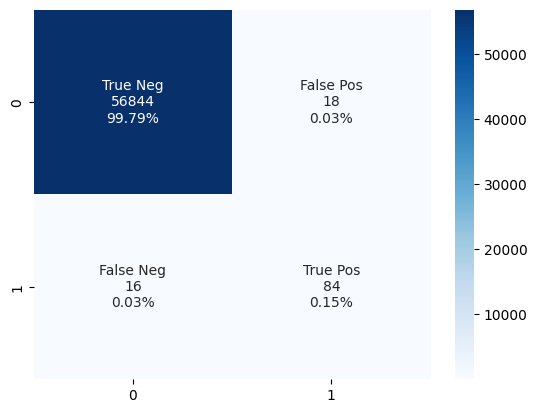

In [12]:
cnf_matrix=confusion_matrix(y, pred_proba)

heatmap_ax = plot_confusion_matrix(cnf_matrix)

plt.savefig('heatmap_confusion_matrix.png')

matrix_graph = open('heatmap_confusion_matrix.png', 'rb').read() # read bytes from file
matrix_graph = base64.b64encode(matrix_graph)  # encode to base64 (bytes)
matrix_graph = matrix_graph.decode()

html_matrix = f"""
<body>
<h2>Confusion Matrix</h2>
<p style="text-align:center;"><img src="data:image/png;base64,{matrix_graph}"></p>
</body>
"""

In [13]:
import numpy
unique, counts = numpy.unique(y.values, return_counts=True)

## Ouputs

In [14]:
import json

profile_pipeline_output = {
    'outputs' : [
        {
          'type': 'web-app',
          'storage': 'inline',
          'source': html_matrix,
        },
    ]
  }

with open('mlpipeline-ui-metadata.json', 'w') as metadata_file:
    json.dump(profile_pipeline_output, metadata_file)

In [15]:
metrics = {
'metrics': [
    {
        'name': 'f1-score',
        'numberValue':  f1,
        'format': 'PERCENTAGE'
    },
    {
        'name': 'recall-score',
        'numberValue':  recall,
        'format': 'PERCENTAGE'       
    },
    {
        'name': 'roc-auc-score',
        'numberValue':  roc_auc,
        'format': 'PERCENTAGE'       
    },
    {
        'name': 'wdata-aug-strategy',
        'numberValue': prep['Balancing'],
        'format': 'RAW'
    },
]
}

with open('mlpipeline-metrics.json', 'w') as f:
    json.dump(metrics, f)

KeyError: 'Imputation'